In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_percentage_error, r2_score
from catboost import CatBoostRegressor, Pool
import shap
import matplotlib.pyplot as plt
import seaborn as sns


c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
df = pd.read_csv("settled.csv")  
target_col = 'Target_Variable/Total Income'

In [3]:
df2= pd.read_csv("LTF Challenge data with dictionary.xlsx - TestData.csv")

In [4]:
def remove_outliers_modified_z(df, threshold=3.5):
    df_clean = df.copy()
    numeric_cols = df_clean.select_dtypes(include=[np.number]).columns

    for col in numeric_cols:
        median = df_clean[col].median()
        mad = np.median(np.abs(df_clean[col] - median))
        if mad == 0:
            continue  # Avoid division by zero
        modified_z_scores = 0.6745 * (df_clean[col] - median) / mad
        df_clean = df_clean[np.abs(modified_z_scores) < threshold]
    
    return df_clean

df_no_outliers = remove_outliers_modified_z(df)


c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\_core\fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\_core\_methods.py:145: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


In [5]:
df.shape

(30940, 105)

In [6]:
df_no_outliers.shape

(0, 105)

In [7]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import RobustScaler

# Step 1: Get numeric columns
numeric_cols = df.select_dtypes(include=[np.number]).columns

# Step 2: Count outliers using IQR method for each column
def count_outliers_iqr(series):
    Q1 = series.quantile(0.25)
    Q3 = series.quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    return ((series < lower) | (series > upper)).sum()

outlier_counts = df[numeric_cols].apply(count_outliers_iqr)
top_10_outlier_cols = outlier_counts.sort_values(ascending=False).head(10).index.tolist()

# Step 3: Copy dataframe for transformation
df_transformed = df.copy()

# Step 4: Log1p transform highly skewed numeric columns
skewness = df[numeric_cols].skew().abs()
highly_skewed = skewness[skewness > 1].index.tolist()

for col in highly_skewed:
    if (df_transformed[col] >= 0).all():
        df_transformed[col] = np.log1p(df_transformed[col])

# Step 5: Apply RobustScaler to all numeric columns
scaler = RobustScaler()
df_transformed[numeric_cols] = scaler.fit_transform(df_transformed[numeric_cols])


In [8]:
#TESTING DATA
# Step 1: Use same numeric columns and highly skewed columns as training data
numeric_cols = df.select_dtypes(include=[np.number]).columns
skewness = df[numeric_cols].skew().abs()
highly_skewed = skewness[skewness > 1].index.tolist()

# Step 2: Create a copy of test data
df2_transformed = df2.copy()

# Step 3: Apply log1p to the same highly skewed columns (only if all values are non-negative)
for col in highly_skewed:
    if (df2_transformed[col] >= 0).all():
        df2_transformed[col] = np.log1p(df2_transformed[col])

# Step 4: Use the same RobustScaler fitted on df to transform df2
scaler = RobustScaler()
scaler.fit(df[numeric_cols])  # Fit ONLY on training data
df2_transformed[numeric_cols] = scaler.transform(df2_transformed[numeric_cols])


In [9]:
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
# Print the list
print("Total numeric columns:", len(numeric_cols))
print("Numeric columns:\n", numeric_cols)

Total numeric columns: 67
Numeric columns:
 ['FarmerID', 'Zipcode', 'No_of_Active_Loan_In_Bureau', 'Avg_Disbursement_Amount_Bureau', 'Non_Agriculture_Income', 'Total_Land_For_Agriculture', 'K022-Proximity to nearest mandi (Km)', 'K022-Proximity to nearest railway (Km)', 'KO22-Village score based on socio-economic parameters (0 to 100)', 'K022-Seasonal Average Rainfall (mm)', 'R022-Seasonal Average Rainfall (mm)', 'K021-Seasonal Average Rainfall (mm)', 'R021-Seasonal Average Rainfall (mm)', 'R020-Seasonal Average Rainfall (mm)', 'Perc_of_house_with_6plus_room', 'Women_15_19_Mothers_or_Pregnant_at_time_of_survey', 'perc_of_pop_living_in_hh_electricity', 'perc_Households_with_Pucca_House_That_Has_More_Than_3_Rooms', 'mat_roof_Metal_GI_Asbestos_sheets', 'perc_of_Wall_material_with_Burnt_brick', 'Households_with_improved_Sanitation_Facility', 'perc_Households_do_not_have_KCC_With_The_Credit_Limit_Of_50k', 'K022-Total Geographical Area (in Hectares)-', 'K022-Net Agri area (in Ha)-', 'K022-Ne

In [10]:
df.set_index('FarmerID', inplace=True)
df2.set_index('FarmerID', inplace=True)

In [11]:
df2.head()

,State,REGION,SEX,CITY,Zipcode,DISTRICT,VILLAGE,MARITAL_STATUS,Location,Address type,...,Rabi Seasons Agro Ecological Sub Zone in 2020,Rabi Seasons Seasonal average groundwater thickness (cm) in 2020,Rabi Seasons Seasonal average groundwater replenishment rate (cm) in 2020,Night light index,Village score based on socio-economic parameters (Non normalised),Village score based on socio-economic parameters (0 to 100),"Village category based on socio-economic parameters (Good, Average, Poor)",Land Holding Index source (Total Agri Area/ no of people),Road density (Km/ SqKm),Target_Variable/Total Income
FarmerID,,,,,,,,,,,,,,,,,,,,,
9.500000e+14,KARNATAKA,SOUTH,M,DHARWAD,580008,DHARWAD,Dharwad,M,"15.2674262,75.1196932",Permanent Address,...,DECCAN PLATU HOT SEMI-ARID ECO-REGION,81.17,38.21,0.95,31.98,49.09,Average,0.03,3.86,NaN
1.720000e+14,KARNATAKA,SOUTH,M,DHARWAD,580006,DHARWAD,Dharwad,M,NaN,NaN,...,DECCAN PLATU HOT SEMI-ARID ECO-REGION,81.17,38.21,0.95,31.98,49.09,Average,0.03,3.86,NaN
2.680000e+14,WEST BENGAL,EAST,M,DHARMAPUR,712102,HUGLI,Ramnagar,M,"23.170456,88.0960386",Permanent Address,...,DECCAN PLATU HOT SEMI-ARID ECO-REGION,93.98,13.66,0.89,27.50,41.82,Poor,0.16,0.00,NaN
6.950000e+14,ANDHRA PRADESH,SOUTH,M,ANANTAPALLI,534111,WEST GODAVARI,Telikicherla,S,NaN,NaN,...,DECCAN PLATEAU (TELANGANA) AND EASTERN GHATS ...,72.95,16.61,0.98,25.90,39.23,Poor,0.23,0.00,NaN
2.770000e+14,ANDHRA PRADESH,SOUTH,M,ANANTAPALLI,534111,WEST GODAVARI,Ananthapalle,M,"16.7160861,81.1152557",Permanent Address,...,DECCAN PLATEAU (TELANGANA) AND EASTERN GHATS ...,72.95,16.61,1.00,23.28,34.99,Poor,14.66,1.58,NaN


In [12]:
df.head()

,State,REGION,SEX,CITY,Zipcode,DISTRICT,VILLAGE,MARITAL_STATUS,Location,Address type,...,Rabi Seasons Agro Ecological Sub Zone in 2020,Rabi Seasons Seasonal average groundwater thickness (cm) in 2020,Rabi Seasons Seasonal average groundwater replenishment rate (cm) in 2020,Night light index,Village score based on socio-economic parameters (Non normalised),Village score based on socio-economic parameters (0 to 100),"Village category based on socio-economic parameters (Good, Average, Poor)",Land Holding Index source (Total Agri Area/ no of people),Road density (Km/ SqKm),Target_Variable/Total Income
FarmerID,,,,,,,,,,,,,,,,,,,,,
1032447758966470,MADHYA PRADESH,CENTRAL,M,VIDISHA,464001,VIDISHA,Ambar,M,"23.5131479,77.8207876",Permanent Address,...,CENTRAL HIGHLANDS (MALWA AND BUNDELKHAND) HOT...,100.95,25.95,0.95,22.33,33.45,Poor,1.96,0.00,800000
1041885888252080,MADHYA PRADESH,CENTRAL,M,PIPARIYA,461775,HOSHANGABAD,Khapar Kheda,M,"22.7184042,78.2180971",Permanent Address,...,CENTRAL HIGHLANDS (MALWA AND BUNDELKHAND) HOT...,82.60,22.76,0.94,27.94,42.54,Average,0.48,3.89,700000
1068465784357340,ODISHA,EAST,M,RAMGARH,754022,CUTTACK,Karanji,S,"20.649898,85.9164129",Permanent Address,...,DECCAN PLATU HOT SEMI-ARID ECO-REGION,91.92,17.60,0.95,26.98,40.98,Poor,0.34,0.00,1295000
1072440196043140,MADHYA PRADESH,CENTRAL,M,PIPARIYA,461775,HOSHANGABAD,Pondi,M,"22.7472362,78.3550004",Permanent Address,...,CENTRAL HIGHLANDS (MALWA AND BUNDELKHAND) HOT...,96.85,19.01,0.93,24.97,37.73,Poor,0.35,0.00,800000
1073642021022590,MADHYA PRADESH,CENTRAL,M,ASHOKNAGAR,473330,ASHOKNAGAR,Amoda,M,"24.8491952,77.6157991",Permanent Address,...,CENTRAL HIGHLANDS (MALWA AND BUNDELKHAND) HOT...,93.67,19.70,0.91,29.20,44.58,Average,0.82,0.00,750000


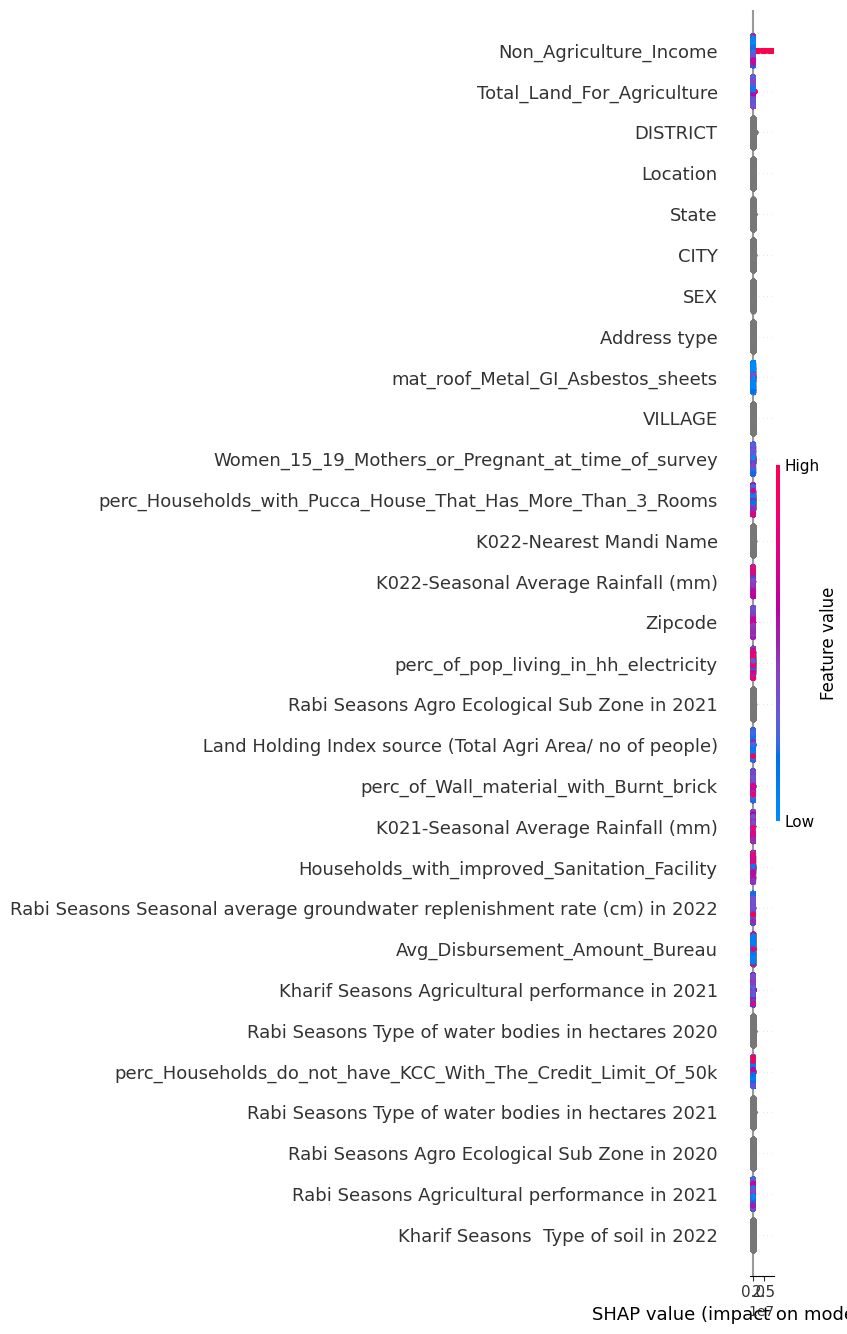

Top 50 Features by SHAP:
['Non_Agriculture_Income', 'Total_Land_For_Agriculture', 'DISTRICT', 'Location', 'State', 'CITY', 'SEX', 'Address type', 'mat_roof_Metal_GI_Asbestos_sheets', 'VILLAGE', 'Women_15_19_Mothers_or_Pregnant_at_time_of_survey', 'perc_Households_with_Pucca_House_That_Has_More_Than_3_Rooms', 'K022-Nearest Mandi Name', 'K022-Seasonal Average Rainfall (mm)', 'Zipcode', 'perc_of_pop_living_in_hh_electricity', 'Rabi Seasons Agro Ecological Sub Zone in 2021', ' Land Holding Index source (Total Agri Area/ no of people)', 'perc_of_Wall_material_with_Burnt_brick', 'K021-Seasonal Average Rainfall (mm)', 'Households_with_improved_Sanitation_Facility', 'Rabi Seasons Seasonal average groundwater replenishment rate (cm) in 2022', 'Avg_Disbursement_Amount_Bureau', 'Kharif Seasons Agricultural performance in 2021', 'Rabi Seasons Type of water bodies in hectares 2020', 'perc_Households_do_not_have_KCC_With_The_Credit_Limit_Of_50k', 'Rabi Seasons Type of water bodies in hectares 2021',

In [13]:
import pandas as pd
import numpy as np
from catboost import CatBoostRegressor, Pool
import shap
import matplotlib.pyplot as plt

# 1. Split numeric and categorical columns
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
categorical_cols = df.select_dtypes(exclude=[np.number]).columns.tolist()

# 2. Define your target and features
target_col = 'Target_Variable/Total Income'  # Change this to your actual target
features = [col for col in df.columns if col != target_col]

# 3. Prepare Pool for CatBoost (handles categorical columns natively)
X = df[features]
y = df[target_col]

cat_features = [col for col in categorical_cols if col in X.columns]
train_pool = Pool(data=X, label=y, cat_features=cat_features)

# 4. Train a baseline CatBoostRegressor
model = CatBoostRegressor(verbose=0, random_state=42)
model.fit(train_pool)

# 5. SHAP explainer
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X)

# 6. SHAP summary plot (top 30 features)
shap.summary_plot(shap_values, X, max_display=30)

# 7. Extract top N features (e.g., 50) by SHAP importance
mean_shap = np.abs(shap_values).mean(axis=0)
shap_importance = pd.Series(mean_shap, index=X.columns).sort_values(ascending=False)
top_features = shap_importance.head(50).index.tolist()

# Optional: Save them
print("Top 50 Features by SHAP:")
print(top_features)


In [14]:
df_top50 = df[top_features + ['Target_Variable/Total Income']]

In [15]:
# 1. Average income per village
df['village_income_avg'] = df.groupby('VILLAGE')['Target_Variable/Total Income'].transform('mean')

# 2. Income vs village average (how much better or worse this farmer is)
df['income_vs_village_avg'] = df['Target_Variable/Total Income'] / df['village_income_avg']

# 3. District-level average number of active loans
df['district_loan_avg'] = df.groupby('DISTRICT')['No_of_Active_Loan_In_Bureau'].transform('mean')

# 4. Farmer's loan burden compared to district average
df['loan_burden_vs_district'] = df['No_of_Active_Loan_In_Bureau'] / df['district_loan_avg']

# 5. District-level average mandi distance (proximity to markets)
df['district_mandi_avg_dist'] = df.groupby('DISTRICT')['K022-Proximity to nearest mandi (Km)'].transform('mean')


In [16]:
# Compute group-level stats from training data (df)
village_income_avg = df.groupby('VILLAGE')['Target_Variable/Total Income'].mean()
district_loan_avg = df.groupby('DISTRICT')['No_of_Active_Loan_In_Bureau'].mean()
district_mandi_avg = df.groupby('DISTRICT')['K022-Proximity to nearest mandi (Km)'].mean()

# Apply those stats to df2 (test data)
df2['village_income_avg'] = df2['VILLAGE'].map(village_income_avg)
df2['district_loan_avg'] = df2['DISTRICT'].map(district_loan_avg)
df2['loan_burden_vs_district'] = df2['No_of_Active_Loan_In_Bureau'] / df2['district_loan_avg']
df2['district_mandi_avg_dist'] = df2['DISTRICT'].map(district_mandi_avg)


In [17]:
df.head()

,State,REGION,SEX,CITY,Zipcode,DISTRICT,VILLAGE,MARITAL_STATUS,Location,Address type,...,Village score based on socio-economic parameters (0 to 100),"Village category based on socio-economic parameters (Good, Average, Poor)",Land Holding Index source (Total Agri Area/ no of people),Road density (Km/ SqKm),Target_Variable/Total Income,village_income_avg,income_vs_village_avg,district_loan_avg,loan_burden_vs_district,district_mandi_avg_dist
FarmerID,,,,,,,,,,,,,,,,,,,,,
1032447758966470,MADHYA PRADESH,CENTRAL,M,VIDISHA,464001,VIDISHA,Ambar,M,"23.5131479,77.8207876",Permanent Address,...,33.45,Poor,1.96,0.00,800000,2.261130e+06,0.353805,3.973890,0.000000,14.881984
1041885888252080,MADHYA PRADESH,CENTRAL,M,PIPARIYA,461775,HOSHANGABAD,Khapar Kheda,M,"22.7184042,78.2180971",Permanent Address,...,42.54,Average,0.48,3.89,700000,7.375000e+05,0.949153,2.097087,0.000000,12.578155
1068465784357340,ODISHA,EAST,M,RAMGARH,754022,CUTTACK,Karanji,S,"20.649898,85.9164129",Permanent Address,...,40.98,Poor,0.34,0.00,1295000,8.492222e+05,1.524925,2.638889,0.378947,13.194444
1072440196043140,MADHYA PRADESH,CENTRAL,M,PIPARIYA,461775,HOSHANGABAD,Pondi,M,"22.7472362,78.3550004",Permanent Address,...,37.73,Poor,0.35,0.00,800000,1.141919e+06,0.700575,2.097087,0.476852,12.578155
1073642021022590,MADHYA PRADESH,CENTRAL,M,ASHOKNAGAR,473330,ASHOKNAGAR,Amoda,M,"24.8491952,77.6157991",Permanent Address,...,44.58,Average,0.82,0.00,750000,1.474690e+06,0.508581,0.821803,0.000000,5.861426


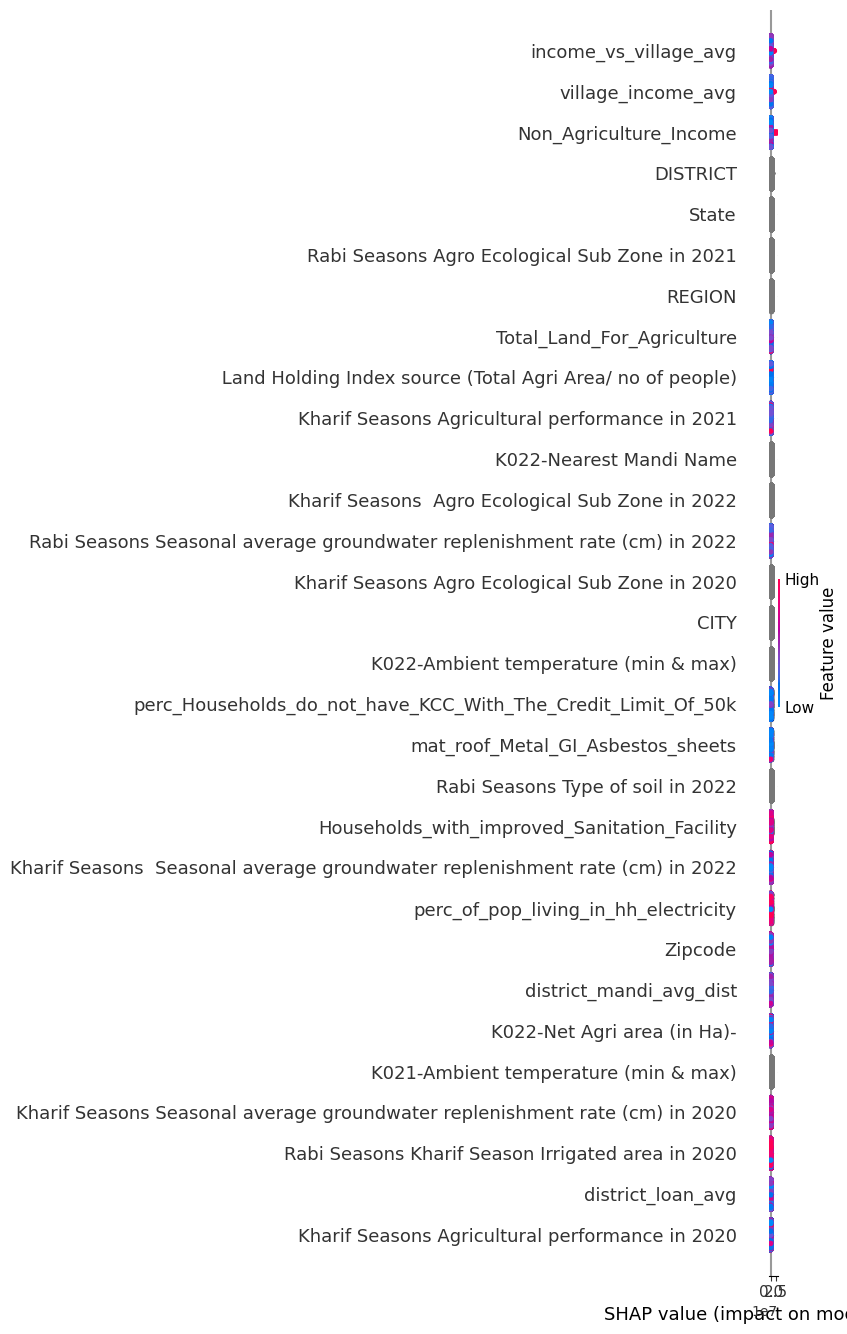

Top 50 Features by SHAP:
['income_vs_village_avg', 'village_income_avg', 'Non_Agriculture_Income', 'DISTRICT', 'State', 'Rabi Seasons Agro Ecological Sub Zone in 2021', 'REGION', 'Total_Land_For_Agriculture', ' Land Holding Index source (Total Agri Area/ no of people)', 'Kharif Seasons Agricultural performance in 2021', 'K022-Nearest Mandi Name', 'Kharif Seasons  Agro Ecological Sub Zone in 2022', 'Rabi Seasons Seasonal average groundwater replenishment rate (cm) in 2022', 'Kharif Seasons Agro Ecological Sub Zone in 2020', 'CITY', 'K022-Ambient temperature (min & max)', 'perc_Households_do_not_have_KCC_With_The_Credit_Limit_Of_50k', 'mat_roof_Metal_GI_Asbestos_sheets', 'Rabi Seasons Type of soil in 2022', 'Households_with_improved_Sanitation_Facility', 'Kharif Seasons  Seasonal average groundwater replenishment rate (cm) in 2022', 'perc_of_pop_living_in_hh_electricity', 'Zipcode', 'district_mandi_avg_dist', 'K022-Net Agri area (in Ha)-', 'K021-Ambient temperature (min & max)', 'Kharif 

In [18]:
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
categorical_cols = df.select_dtypes(exclude=[np.number]).columns.tolist()

# 2. Define your target and features
target_col = 'Target_Variable/Total Income'  # Change this to your actual target
features = [col for col in df.columns if col != target_col]

# 3. Prepare Pool for CatBoost (handles categorical columns natively)
X = df[features]
y = df[target_col]

cat_features = [col for col in categorical_cols if col in X.columns]
train_pool = Pool(data=X, label=y, cat_features=cat_features)

# 4. Train a baseline CatBoostRegressor
model = CatBoostRegressor(verbose=0, random_state=42)
model.fit(train_pool)

# 5. SHAP explainer
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X)

# 6. SHAP summary plot (top 30 features)
shap.summary_plot(shap_values, X, max_display=30)

# 7. Extract top N features (e.g., 50) by SHAP importance
mean_shap = np.abs(shap_values).mean(axis=0)
shap_importance = pd.Series(mean_shap, index=X.columns).sort_values(ascending=False)
top_features = shap_importance.head(50).index.tolist()

# Optional: Save them
print("Top 50 Features by SHAP:")
print(top_features)

In [19]:
# Step 1: Groundwater Replenishment Average
df['avg_groundwater_replenishment'] = df[[
    'Kharif Seasons Seasonal average groundwater replenishment rate (cm) in 2020',
    'Kharif Seasons Seasonal average groundwater replenishment rate (cm) in 2021',
    'Kharif Seasons  Seasonal average groundwater replenishment rate (cm) in 2022',
    'Rabi Seasons Seasonal average groundwater replenishment rate (cm) in 2022'
]].mean(axis=1)

# Step 2: Kharif Agricultural Score Average
df['kharif_agri_score_avg'] = df[[
    'Kharif Seasons Agricultural Score in 2020',
    'Kharif Seasons Agricultural Score in 2021'
]].mean(axis=1)

# Step 3: Rabi Agricultural Score Average
df['rabi_agri_score_avg'] = df[[
    'Rabi Seasons Agricultural Score in 2020',
    'Rabi Seasons Agricultural Score in 2021'
]].mean(axis=1)

# Step 4: Average Seasonal Rainfall
df['avg_rainfall'] = df[[
    'K021-Seasonal Average Rainfall (mm)',
    'R022-Seasonal Average Rainfall (mm)',
    'K022-Seasonal Average Rainfall (mm)'
]].mean(axis=1)

# Step 5: Total Agri Performance Score (Kharif + Rabi)
df['total_agri_performance'] = df[[
    'Kharif Seasons Agricultural performance in 2020',
    'Kharif Seasons Agricultural performance in 2021',
    'Kharif Seasons  Agricultural performance in 2022',
    'Rabi Seasons Agricultural performance in 2020'
]].mean(axis=1)

# Step 6: Combined Soil Feature (2022 only)
df['soil_type_encoded'] = df[[
    'Kharif Seasons  Type of soil in 2022',
    'Rabi Seasons Type of soil in 2022'
]].astype(str).agg('_'.join, axis=1)

# (Optional) encode soil_type_encoded using LabelEncoder if model needs numeric input
from sklearn.preprocessing import LabelEncoder
df['soil_type_encoded'] = LabelEncoder().fit_transform(df['soil_type_encoded'])

# Step 7: Village Socio-Economic Score Adjusted
df['socio_econ_adjusted'] = df[
    'KO22-Village score based on socio-economic parameters (0 to 100)'
] * (df['perc_Households_with_Pucca_House_That_Has_More_Than_3_Rooms'] / 100 + 1)


In [20]:
# Step 1
df2['avg_groundwater_replenishment'] = df2[[  
    'Kharif Seasons Seasonal average groundwater replenishment rate (cm) in 2020',
    'Kharif Seasons Seasonal average groundwater replenishment rate (cm) in 2021',
    'Kharif Seasons  Seasonal average groundwater replenishment rate (cm) in 2022',
    'Rabi Seasons Seasonal average groundwater replenishment rate (cm) in 2022'
]].mean(axis=1)

# Step 2
df2['kharif_agri_score_avg'] = df2[[  
    'Kharif Seasons Agricultural Score in 2020',
    'Kharif Seasons Agricultural Score in 2021'
]].mean(axis=1)

# Step 3
df2['rabi_agri_score_avg'] = df2[[  
    'Rabi Seasons Agricultural Score in 2020',
    'Rabi Seasons Agricultural Score in 2021'
]].mean(axis=1)

# Step 4
df2['avg_rainfall'] = df2[[  
    'K021-Seasonal Average Rainfall (mm)',
    'R022-Seasonal Average Rainfall (mm)',
    'K022-Seasonal Average Rainfall (mm)'
]].mean(axis=1)

# Step 5
df2['total_agri_performance'] = df2[[  
    'Kharif Seasons Agricultural performance in 2020',
    'Kharif Seasons Agricultural performance in 2021',
    'Kharif Seasons  Agricultural performance in 2022',
    'Rabi Seasons Agricultural performance in 2020'
]].mean(axis=1)

# Step 6: Combine soil type and encode
df2['soil_type_encoded'] = df2[[  
    'Kharif Seasons  Type of soil in 2022',
    'Rabi Seasons Type of soil in 2022'
]].astype(str).agg('_'.join, axis=1)


from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
le.fit(df['soil_type_encoded'])  # Fit on train data

# Update the LabelEncoder to handle unseen labels by adding them temporarily
le_classes = le.classes_.tolist()
for val in df2['soil_type_encoded'].unique():
    if val not in le_classes:
        le_classes.append(val)
le.classes_ = np.array(le_classes)
df2['soil_type_encoded'] = le.transform(df2['soil_type_encoded'])  # Apply on test

# Step 7
df2['socio_econ_adjusted'] = df2[  
    'KO22-Village score based on socio-economic parameters (0 to 100)'
] * (df2['perc_Households_with_Pucca_House_That_Has_More_Than_3_Rooms'] / 100 + 1)


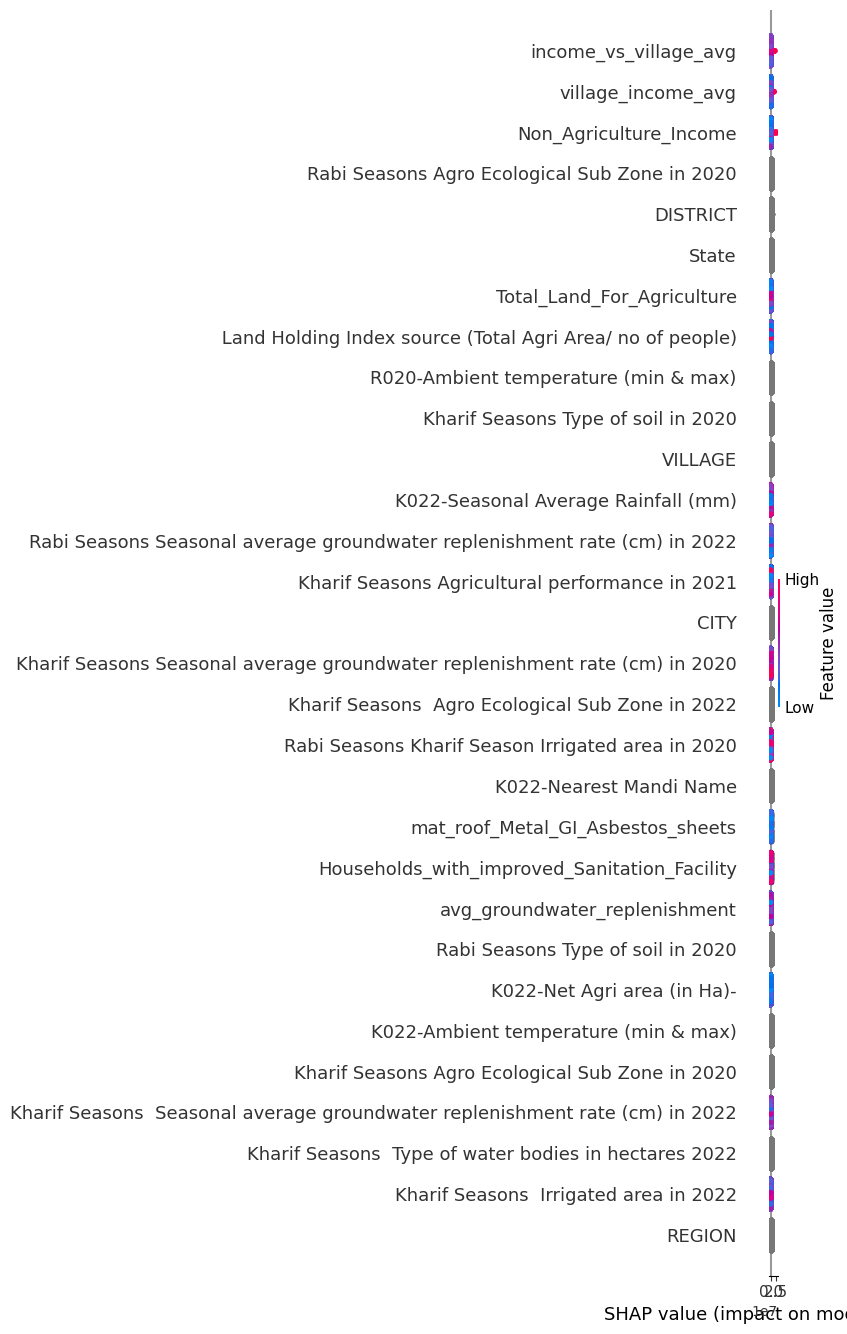

Top 50 Features by SHAP:
['income_vs_village_avg', 'village_income_avg', 'Non_Agriculture_Income', 'Rabi Seasons Agro Ecological Sub Zone in 2020', 'DISTRICT', 'State', 'Total_Land_For_Agriculture', ' Land Holding Index source (Total Agri Area/ no of people)', 'R020-Ambient temperature (min & max)', 'Kharif Seasons Type of soil in 2020', 'VILLAGE', 'K022-Seasonal Average Rainfall (mm)', 'Rabi Seasons Seasonal average groundwater replenishment rate (cm) in 2022', 'Kharif Seasons Agricultural performance in 2021', 'CITY', 'Kharif Seasons Seasonal average groundwater replenishment rate (cm) in 2020', 'Kharif Seasons  Agro Ecological Sub Zone in 2022', 'Rabi Seasons Kharif Season Irrigated area in 2020', 'K022-Nearest Mandi Name', 'mat_roof_Metal_GI_Asbestos_sheets', 'Households_with_improved_Sanitation_Facility', 'avg_groundwater_replenishment', 'Rabi Seasons Type of soil in 2020', 'K022-Net Agri area (in Ha)-', 'K022-Ambient temperature (min & max)', 'Kharif Seasons Agro Ecological Sub Z

In [21]:
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
categorical_cols = df.select_dtypes(exclude=[np.number]).columns.tolist()

# 2. Define your target and features
target_col = 'Target_Variable/Total Income'  # Change this to your actual target
features = [col for col in df.columns if col != target_col]

# 3. Prepare Pool for CatBoost (handles categorical columns natively)
X = df[features]
y = df[target_col]

cat_features = [col for col in categorical_cols if col in X.columns]
train_pool = Pool(data=X, label=y, cat_features=cat_features)

# 4. Train a baseline CatBoostRegressor
model = CatBoostRegressor(verbose=0, random_state=42)
model.fit(train_pool)

# 5. SHAP explainer
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X)

# 6. SHAP summary plot (top 30 features)
shap.summary_plot(shap_values, X, max_display=30)

# 7. Extract top N features (e.g., 50) by SHAP importance
mean_shap = np.abs(shap_values).mean(axis=0)
shap_importance = pd.Series(mean_shap, index=X.columns).sort_values(ascending=False)
top_features = shap_importance.head(50).index.tolist()

# Optional: Save them
print("Top 50 Features by SHAP:")
print(top_features)

In [22]:
import numpy as np
import pandas as pd

# Use your existing SHAP importance
shap_df = shap_importance  # Already a Series with index = feature names

# Step 1: Take top 50 features
top_50_features = shap_df.head(50).index.tolist()

# Step 2: Subset numeric columns only
numeric_top_50 = df[top_50_features].select_dtypes(include=[np.number])

# Step 3: Correlation matrix
corr_matrix = numeric_top_50.corr().abs()

# Step 4: Extract upper triangle (to avoid duplicate pairs)
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

# Step 5: Find highly correlated pairs (r > 0.85)
correlated_pairs = [
    (col1, col2)
    for col1 in upper.columns
    for col2 in upper.index
    if upper.loc[col2, col1] > 0.85
]

# Step 6: Drop the one with lower SHAP score
shap_scores = shap_df.to_dict()
features_to_drop = set()

for col1, col2 in correlated_pairs:
    if shap_scores.get(col1, 0) >= shap_scores.get(col2, 0):
        features_to_drop.add(col2)
    else:
        features_to_drop.add(col1)

# Step 7: Final filtered features
final_features = [f for f in top_50_features if f not in features_to_drop]

# Output
print(f"Dropped {len(features_to_drop)} correlated features:")
print(sorted(features_to_drop))

print(f"\nFinal top features after removing correlations: {len(final_features)}")
print(final_features)



Dropped 2 correlated features:
['K022-Total Geographical Area (in Hectares)-', 'Kharif Seasons  Seasonal average groundwater replenishment rate (cm) in 2022']

Final top features after removing correlations: 48
['income_vs_village_avg', 'village_income_avg', 'Non_Agriculture_Income', 'Rabi Seasons Agro Ecological Sub Zone in 2020', 'DISTRICT', 'State', 'Total_Land_For_Agriculture', ' Land Holding Index source (Total Agri Area/ no of people)', 'R020-Ambient temperature (min & max)', 'Kharif Seasons Type of soil in 2020', 'VILLAGE', 'K022-Seasonal Average Rainfall (mm)', 'Rabi Seasons Seasonal average groundwater replenishment rate (cm) in 2022', 'Kharif Seasons Agricultural performance in 2021', 'CITY', 'Kharif Seasons Seasonal average groundwater replenishment rate (cm) in 2020', 'Kharif Seasons  Agro Ecological Sub Zone in 2022', 'Rabi Seasons Kharif Season Irrigated area in 2020', 'K022-Nearest Mandi Name', 'mat_roof_Metal_GI_Asbestos_sheets', 'Households_with_improved_Sanitation_Fac

In [23]:
# Remove 'income_vs_village_avg' from final_features when using df2
final_features_test = [col for col in final_features if col != 'income_vs_village_avg']

X_test = df2[final_features_test]

test_cat_features = [col for col in final_features_test if col in categorical_cols]
test_pool = Pool(data=X_test, cat_features=test_cat_features)


In [24]:
# Define columns used to identify 'settled' vs 'nomad'
key_columns = ['Location', 'Ownership', 'Address type']  # change if you used different columns

# Split df2 into settled and nomad groups
df2_settled = df2.dropna(subset=key_columns)
df2_nomad = df2[df2[key_columns].isnull().any(axis=1)]

print(f"Settled rows in df2: {df2_settled.shape[0]}")
print(f"Nomad rows in df2: {df2_nomad.shape[0]}")


Settled rows in df2: 6417
Nomad rows in df2: 3569


In [25]:
import pandas as pd
import numpy as np
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import RandomForestRegressor

# Target column
target_col = 'Target_Variable/Total Income'

# Define feature set (ensure valid features are used)
X = df[final_features_test]
y = df[target_col]

# Identify categorical and numerical features
cat_cols = X.select_dtypes(include=['object', 'category']).columns.tolist()
num_cols = [col for col in X.columns if col not in cat_cols]

# Preprocessing
preprocessor = ColumnTransformer(
    transformers=[
        ('num', SimpleImputer(strategy='mean'), num_cols),
        ('cat', make_pipeline(SimpleImputer(strategy='most_frequent'),
                              OneHotEncoder(handle_unknown='ignore')), cat_cols)
    ]
)

# Define Random Forest pipeline
model = RandomForestRegressor(random_state=42, n_jobs=-1)
pipeline = make_pipeline(preprocessor, model)

# ✅ Fit model on full df
pipeline.fit(X, y)

# ✅ Predict on actual test set df2_settled using same features
df2_settled['Predicted_Income'] = pipeline.predict(df2_settled[final_features_test])


C:\Users\user\AppData\Local\Temp\ipykernel_13160\775763481.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2_settled['Predicted_Income'] = pipeline.predict(df2_settled[final_features_test])


In [26]:
df2_settled

,State,REGION,SEX,CITY,Zipcode,DISTRICT,VILLAGE,MARITAL_STATUS,Location,Address type,...,loan_burden_vs_district,district_mandi_avg_dist,avg_groundwater_replenishment,kharif_agri_score_avg,rabi_agri_score_avg,avg_rainfall,total_agri_performance,soil_type_encoded,socio_econ_adjusted,Predicted_Income
FarmerID,,,,,,,,,,,,,,,,,,,,,
9.500000e+14,KARNATAKA,SOUTH,M,DHARWAD,580008,DHARWAD,Dharwad,M,"15.2674262,75.1196932",Permanent Address,...,0.000000,6.854386,31.7350,38.175,40.955,750.240000,35.3200,8,49.085233,1034740.00
2.680000e+14,WEST BENGAL,EAST,M,DHARMAPUR,712102,HUGLI,Ramnagar,M,"23.170456,88.0960386",Permanent Address,...,0.000000,11.021277,21.0850,21.155,29.060,1027.386667,13.6450,9,41.818924,1039047.05
2.770000e+14,ANDHRA PRADESH,SOUTH,M,ANANTAPALLI,534111,WEST GODAVARI,Ananthapalle,M,"16.7160861,81.1152557",Permanent Address,...,2.589474,16.217073,17.2600,41.080,44.725,832.563333,42.9550,10,35.690845,989720.96
6.090000e+14,ANDHRA PRADESH,SOUTH,F,NALLAJERLA,534176,WEST GODAVARI,Pothavaram,M,"17.0197257,81.4122823",Permanent Address,...,3.021053,16.217073,17.2600,37.220,46.580,832.563333,34.6675,10,31.929944,1089425.00
1.120000e+15,ANDHRA PRADESH,SOUTH,M,NALLAJERLA,534176,WEST GODAVARI,Pothavaram,M,"17.0143731,81.4115864",Permanent Address,...,0.863158,16.217073,17.2600,37.220,46.580,832.563333,34.6675,10,31.929944,1112523.23
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4.220000e+14,MAHARASHTRA,WEST,M,KADEGAON,415305,SANGLI,Ambegaon,M,"17.1482955,74.2298546",Permanent Address,...,0.576087,15.415094,30.7075,24.550,37.700,797.146667,26.4075,8,NaN,1429430.00
4.000000e+14,JHARKHAND,EAST,M,GHAGHRA,835233,GUMLA,Bhandariya,M,"23.1145442,84.6450314",Permanent Address,...,6.000000,14.166667,24.9325,37.795,42.000,921.660000,29.5100,9,NaN,1052549.00
1.680000e+14,MAHARASHTRA,WEST,M,KOREGAON,415501,SATARA,Koregaon,M,"17.6871033,74.15968",Permanent Address,...,0.729730,8.544444,24.1275,10.045,26.000,492.830000,8.6325,8,NaN,776590.80
